In [2]:
using RxInfer, Random, Distributions, Plots, Flux, DelimitedFiles, StableRNGs
using ReactiveMP
using CCMP
using Base
using SpecialFunctions
using BenchmarkTools
using StatsFuns

  ** incremental compilation may be fatally broken for this module **



  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



In [3]:
# to check that matched with Semih
sunspot_semih = readdlm("data/SN_Akbayrak.csv")
semih_observations = map(Int, sunspot_semih[:,2]);

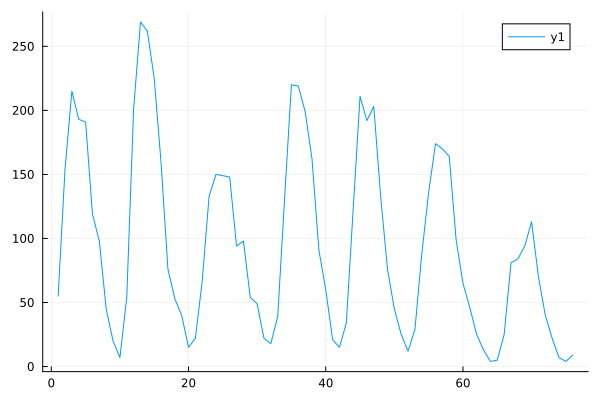

In [4]:
sunspot = readdlm("data/SN_y_tot_V2.0.csv", ';')
select_1945_2020 = filter((s) -> s[1] > 1945 && s[1] < 2021, collect(eachrow(sunspot)))
observations = map((s) -> round(s[2]), select_1945_2020)
not_rounded = map((s) -> s[2], select_1945_2020)
@assert semih_observations == observations
plot(observations)


In [5]:
hello(x) = softplus(x)

@meta function sunspot_meta(rng, nr_samples, nr_iterations, optimizer)
    hello() -> CVI(rng, nr_samples, nr_iterations, optimizer, ForwardDiffGrad(), 100, Val(true), true)
end;

@model function sunspot_model(nr_observations)

    γ ~ GammaShapeRate(1000.0, 2)
    z = randomvar(nr_observations)
    y = datavar(Float64, nr_observations)
    
    # specify estimate of initial location
    z[1] ~ GammaShapeRate(1, γ)
    y[1] ~ Poisson(z[1])
    for t in 2:nr_observations
        # specify state transition model
        z[t] ~ GammaShapeRate(identity(z[t-1]), γ)
        y[t] ~ Poisson(z[t])
    end
end

@meta function sunspot_meta(rng, nr_samples, nr_iterations, optimizer)
    identity() -> CVI(rng, nr_samples, nr_iterations, optimizer, ForwardDiffGrad(), 100, Val(true), false)
end;

@constraints function sunspot_constraints()
    q(γ, z) = q(γ)q(z)
    q(z) = q(z[begin])..q(z[end])
end;

@rule GammaShapeRate(:β, Marginalisation) (q_out::Gamma, q_α::SampleList, ) = begin 
    return GammaShapeRate(mean(q_α)+1, mean(q_out))
end

In [6]:
@average_energy GammaShapeRate (q_out::Any, q_α::SampleList, q_β::Any) = begin
    q_α_mean = mean(q_α)
    q_α_var = var(q_α)
    q_α_matched = GammaShapeRate(q_α_mean^2/q_α_var, q_α_mean/q_α_var)
    mean(loggamma, q_α_matched) - mean(q_α) * mean(log, q_β) - (mean(q_α_matched) - 1.0) * mean(log, q_out) + mean(q_β) * mean(q_out)
end

In [7]:
# z_init = map(r -> NormalMeanPrecision(r, 10), 1:50)
nr_observations = length(observations)
@time results = inference(
    model = sunspot_model(nr_observations),
    data = (y = observations,),
    iterations = 10,
    free_energy = true,
    constraints = sunspot_constraints(),
    meta = sunspot_meta(StableRNG(42), 1000, 10, Flux.Descent(0.001)),
    initmarginals = (γ=Gamma(2, 1), z=Gamma(2, 1))
)

 14.789387 seconds (50.28 M allocations: 3.035 GiB, 7.84% gc time, 96.62% compilation time)


Inference results:
  Posteriors       | available for (γ, z)
  Free Energy:     | Real[7263.11, 6318.32, 6265.64, 6261.72, 6262.76, 6264.23, 6263.35, 6262.09, 6262.85, 6262.32]


In [8]:
@benchmark inference(
    model = sunspot_model(nr_observations),
    data = (y = observations,),
    iterations = 10,
    free_energy = true,
    constraints = sunspot_constraints(),
    meta = sunspot_meta(StableRNG(42), 1000, 10, Flux.Descent(0.001)),
    initmarginals = (γ=Gamma(2.0, 1), z=Gamma(2.0, 1))
)

BenchmarkTools.Trial: 12 samples with 1 evaluation.
 Range (min … max):  435.191 ms … 454.313 ms  ┊ GC (min … max): 7.88% … 7.62%
 Time  (median):     444.536 ms               ┊ GC (median):    8.00%
 Time  (mean ± σ):   445.030 ms ±   6.192 ms  ┊ GC (mean ± σ):  7.83% ± 0.70%

  ▁      ▁         ▁█        ▁   ▁   ▁             ▁  ▁ ▁     ▁  
  █▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁██▁▁▁▁▁▁▁▁█▁▁▁█▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁█▁█▁▁▁▁▁█ ▁
  435 ms           Histogram: frequency by time          454 ms <

 Memory estimate: 212.76 MiB, allocs estimate: 5735319.

In [13]:
# plot estimates for location
posteriours = results.posteriors[:z][end]
means = map(mean, posteriours);

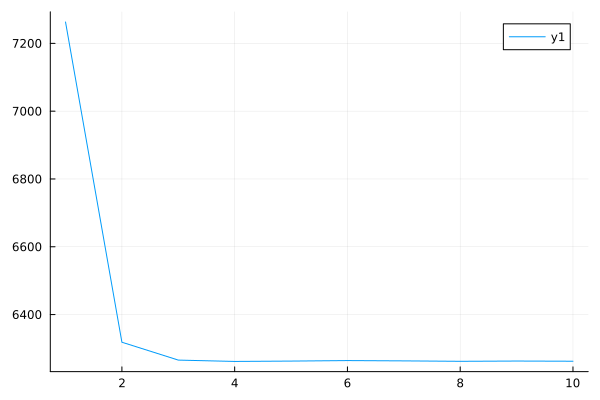

In [14]:
plot(results.free_energy[1:end])

In [15]:
open("estimations/cvi_sunspot_results.csv", "w") do io
    writedlm(io, [means ribbon])
end

open("estimations/cvi_fe_sunspot_results.csv", "w") do io
    writedlm(io, [results.free_energy])
end

In [16]:
sqrt(mean((not_rounded - means).^2))

34.404404002391445